In [52]:
import os
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [53]:
def load_images_labels(folder, image_size=(64, 64)):
    X, y = [], []
    for label in sorted(os.listdir(folder)):
        person_dir = os.path.join(folder, label)
        if not os.path.isdir(person_dir):
            continue
        for fname in os.listdir(person_dir):
            fpath = os.path.join(person_dir, fname)
            img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, image_size)
            X.append(img.flatten())
            y.append(label)
    return np.array(X), np.array(y)

In [54]:
train_dir = "orl_faces_train"
test_dir = "orl_faces_test"

X_train, y_train = load_images_labels(train_dir) # i split the data 80:20
X_test, y_test = load_images_labels(test_dir)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (320, 4096), Test: (80, 4096)


In [55]:
le = LabelEncoder() #convert s1, s2, s3... to 0, 1, 2...
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

print(f"Encoded labels: {y_train_enc}")


Encoded labels: [ 0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2
  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5
  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8
  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14
 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17
 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20
 21 21 21 21 21 21 21 21 22 22 22 22 22 22 22 22 23 23 23 23 23 23 23 23
 24 24 24 24 24 24 24 24 25 25 25 25 25 25 25 25 26 26 26 26 26 26 26 26
 27 27 27 27 27 27 27 27 28 28 28 28 28 28 28 28 29 29 29 29 29 29 29 29
 30 30 30 30 30 30 30 30 31 31 31 31 31 31 31 31 32 32 32 32 32 32 32 32
 33 33 33 33 33 33 33 33 34 34 34 34 34 34 34 34 35 35 35 35 35 35 35 35
 36 36 36 36 36 36 36 36 37 37 37 37 37 37 37 37 38 38 38 38 38 38 38 38
 39 39 39 39 39 39 39 39]


In [ ]:
# # Reduce dimensionality
# pca = PCA(n_components=100, random_state=42) # each pc is an eigenface
# X_train_pca = pca.fit_transform(X_train)
# X_test_pca = pca.transform(X_test)


# # Train SVM
# clf = SVC(kernel='linear', probability=True, random_state=42)
# clf.fit(X_train_pca, y_train_enc)

SVC(kernel='linear', probability=True, random_state=42)

In [ ]:
# y_pred = clf.predict(X_test_pca)
# acc = accuracy_score(y_test_enc, y_pred)
# print(f"Test accuracy: {acc:.2%}")

Test accuracy: 97.50%


---

## from scratch PCA

In [58]:
from pca import PCA_
pca_ = PCA_(num_components=100)
X_train_pca_ = pca_.fit(X_train)
X_train_pca_ = pca_.transform(X_train)
X_test_pca_ = pca_.transform(X_test)

# Train SVM
clf_ = SVC(kernel='linear', probability=True, random_state=42)
clf_.fit(X_train_pca_, y_train_enc)

SVC(kernel='linear', probability=True, random_state=42)

In [ ]:
# y_pred_ = clf_.predict(X_test_pca_)
# acc_ = accuracy_score(y_test_enc, y_pred_)
# print(f"Test accuracy (PCA_): {acc_:.2%}")

Test accuracy (PCA_): 97.50%


In [60]:
# Euclidean NN with threshold
threshold = 4000  # Adjust as needed

y_pred_euclid_thresh = []
for test_vec in X_test_pca_:
    # Compute Euclidean distances to all train samples
    dists = np.sqrt(np.sum((X_train_pca_ - test_vec) ** 2, axis=1))
    min_idx = np.argmin(dists)
    min_dist = dists[min_idx]
    if min_dist < threshold:
        y_pred_euclid_thresh.append(y_train_enc[min_idx])
    else:
        y_pred_euclid_thresh.append(-1)  # -1 for unknown

y_pred_euclid_thresh = np.array(y_pred_euclid_thresh)
mask_known = y_pred_euclid_thresh != -1
if np.any(mask_known):
    acc_known = accuracy_score(y_test_enc[mask_known], y_pred_euclid_thresh[mask_known])
    print(f"Test accuracy (PCA_ + Euclidean NN, threshold={threshold}): {acc_known:.2%}")
else:
    print("No known predictions (all classified as unknown).")
print(f"Unknown predictions: {(~mask_known).sum()} out of {len(y_pred_euclid_thresh)}")

Test accuracy (PCA_ + Euclidean NN, threshold=4000): 97.50%
Unknown predictions: 0 out of 80


In [65]:
import cv2
import numpy as np

def predict_single_image(img_path, pca_, X_train_pca_, y_train_enc, le, threshold=4000):
    # 1. Load and preprocess image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (64, 64))
    img_flat = img.flatten().reshape(1, -1)
    
    # 2. Transform using PCA_
    img_pca = pca_.transform(img_flat)
    
    # 3. Compute Euclidean distances to all train samples
    dists = np.sqrt(np.sum((X_train_pca_ - img_pca) ** 2, axis=1))
    min_idx = np.argmin(dists)
    min_dist = dists[min_idx]
    
    # 4. Predict label or unknown
    if min_dist < threshold:
        pred_label_enc = y_train_enc[min_idx]
        pred_label = le.inverse_transform([pred_label_enc])[0]
    else:
        pred_label = "unknown"
    
    return pred_label, min_dist

# Example usage:
pred, dist = predict_single_image("orl_faces_test/s30/8.pgm", pca_, X_train_pca_, y_train_enc, le, threshold=4000)
print(f"Predicted label: {pred}, Distance: {dist}")

Predicted label: s30, Distance: 975.4194460833603


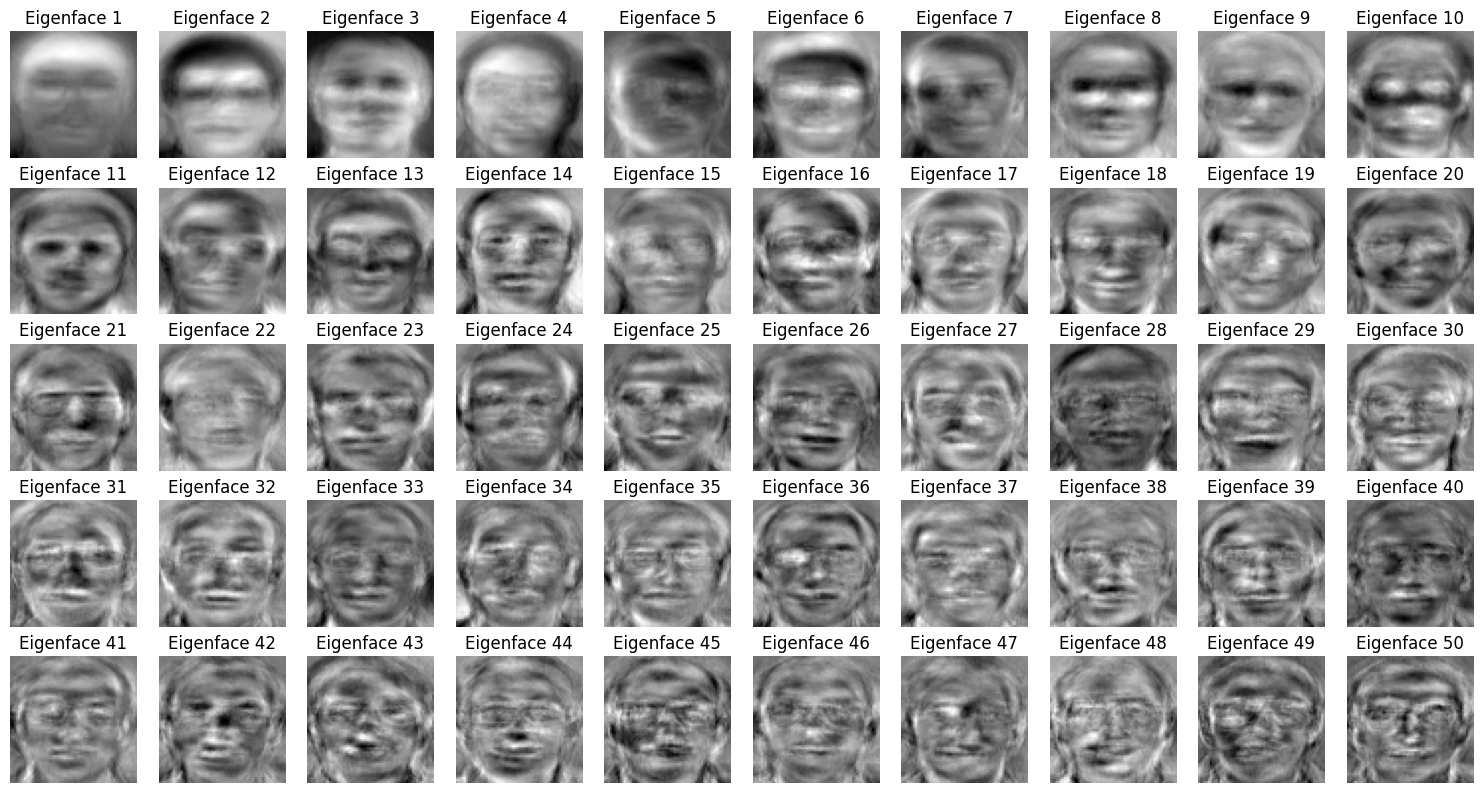

In [ ]:
import matplotlib.pyplot as plt

eigenfaces = pca_.principle_components.reshape((100, 64, 64))  # 100 eigenfaces of size 64x64

fig, axes = plt.subplots(5, 10, figsize=(15, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(eigenfaces[i], cmap='gray')
    ax.set_title(f"Eigenface {i+1}")
    ax.axis('off')
plt.tight_layout()
plt.show()

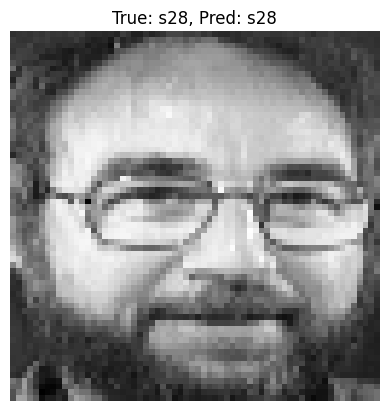

In [ ]:
import matplotlib.pyplot as plt

idx = 40  # Change index to see other test images
img = X_test[idx].reshape(64, 64)
true_label = le.inverse_transform([y_test_enc[idx]])[0]
pred_label = le.inverse_transform([y_pred_[idx]])[0]

plt.imshow(img, cmap='gray')
plt.title(f"True: {true_label}, Pred: {pred_label}")
plt.axis('off')
plt.show()

In [ ]:
import joblib

# Save PCA model
joblib.dump(pca, "model/pca_model.joblib")

# Save SVM classifier
joblib.dump(clf, "model/svm_model.joblib")

# Save label encoder
joblib.dump(le, "model/label_encoder.joblib")

print("Models exported!")

Models exported!
